# Forewords
This part of the project is about learning to handle the pytorch library in case of sound classification/recognition.
For this part I will use the SPEECHCOMMANDS dataset from the torchaudio library, downloadable by using :
 `torchaudio.datasets.SPEECHCOMMANDS('{destination_library}', download=True)`
I will follow the microsoft tutorial on sound recognition from this site:
 [https://learn.microsoft.com/en-us/training/modules/intro-audio-classification-pytorch/](https://learn.microsoft.com/en-us/training/modules/intro-audio-classification-pytorch/)
(I do not own the code, it is only used for educational purposes)


## Importing the packages

In [31]:
# import the packages
import os
import numpy as np
import pandas as pd
import IPython.display as ipd
import matplotlib.pyplot as plt
from pathlib import Path

import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, models, transforms
from torchinfo import summary


## Cheking the audio backend

In [2]:
print(torchaudio.list_audio_backends()) 

['soundfile']


## Setting up the device

In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


# Introduction to Audio data


## Data retrieval

In [4]:
default_dir = os.getcwd()
folder = 'Data'
print(f'Data directory will be: {default_dir}/{folder}')

if os.path.isdir(folder):
    print("Data folder exists.")
else:
    print("Creating folder.")
    os.mkdir(folder)


Data directory will be: /Users/loicbermudez/Documents/ULB/ULB_PROJECT/Computing_Project/LISA-ProjectH419/Sound_Classification/Data
Data folder exists.


In [5]:
### uncomment the following line to download the dataset. WARNING you need 2.26 GB of free memory space to download it

# trainset_speechcommands = torchaudio.datasets.SPEECHCOMMANDS('./Data/', download=True)

Here we visualize the different classes composing the dataset. There are 36 different command speechs and therefore 36 different labels

In [6]:
os.chdir(f'./Data/SpeechCommands/speech_commands_v0.02/')
labels = [name for name in os.listdir('.') if os.path.isdir(name)]
# back to default directory
os.chdir(default_dir)
print(f'Total Labels: {len(labels)} \n')
print(f'Label Names: {labels}')

Total Labels: 36 

Label Names: ['right', 'eight', 'cat', 'tree', 'backward', 'learn', 'bed', 'happy', 'go', 'dog', 'no', 'wow', 'follow', 'nine', 'left', 'stop', 'three', '_background_noise_', 'sheila', 'one', 'bird', 'zero', 'seven', 'up', 'visual', 'marvin', 'two', 'house', 'down', 'six', 'yes', 'on', 'five', 'forward', 'off', 'four']


## To tensor conversion

When loading the sound file (in wav format here) we can split the audio file into multiple frames and setting optionally an offset (those are interesting when processing complex soundwaves).
The `.load()` method returns two things:
- the wave form as a tensor (what we seek).
- the sample rate: the rate (frequency) at which the sound has been sampled.

In [7]:
filename = './Data/SpeechCommands/speech_commands_v0.02/yes/00f0204f_nohash_0.wav'
waveform, sample_rate = torchaudio.load(uri=filename, num_frames=3)
print(f'waveform tensor with 3 frames:  {waveform} \n')
waveform, sample_rate = torchaudio.load(uri=filename, num_frames=3, frame_offset =2) ## frames + offset
print(f'waveform tensor with 2 frame_offsets: {waveform} \n')
waveform, sample_rate = torchaudio.load(uri=filename)
print(f'waveform tensor:  {waveform}' )

waveform tensor with 3 frames:  tensor([[0.0005, 0.0007, 0.0005]]) 

waveform tensor with 2 frame_offsets: tensor([[0.0005, 0.0004, 0.0007]]) 

waveform tensor:  tensor([[0.0005, 0.0007, 0.0005,  ..., 0.0008, 0.0008, 0.0007]])


In [8]:
def plot_audio(filename):
    waveform, sample_rate = torchaudio.load(filename)

    print("Shape of waveform: {}".format(waveform.size())) ## same as print(f"Shape of waveform: {waveform.size()})
    print("Sample rate of waveform: {}".format(sample_rate))

    ### here we plot the soundwave of the file (same as ploting an image from the mnist
    plt.figure()
    plt.plot(waveform.t().numpy())

    return waveform, sample_rate

Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


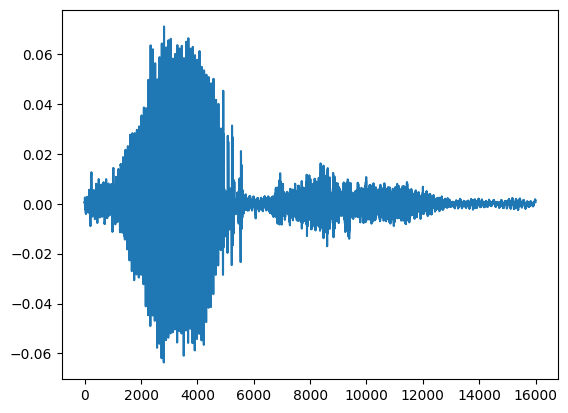

In [9]:
filename = "./data/SpeechCommands/speech_commands_v0.02/yes/00f0204f_nohash_0.wav"
waveform, sample_rate = plot_audio(filename)
### the following allows to display a player allowing to play the desired sound file
ipd.Audio(waveform.numpy(), rate=sample_rate) ## it needs the waveform as a numpy array and need the sample rate in order to correctly go through all the values

## we can see that the sample rate is of 16000 points, knowing this we know that
## the frequency is of 16000 Hz and therefore analyzes the sound 16,000 times in 1 second

Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


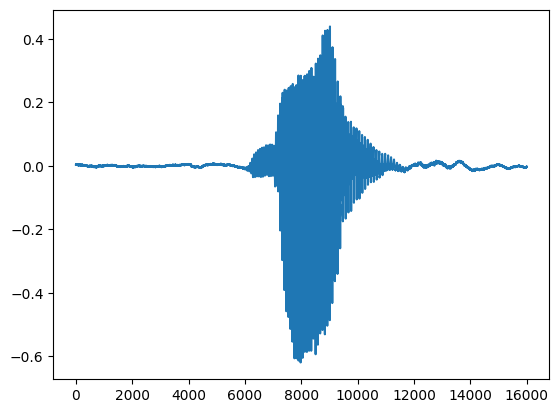

In [10]:
filename = "./Data/SpeechCommands/speech_commands_v0.02/no/0b40aa8e_nohash_0.wav"
waveform, sample_rate = plot_audio(filename)
ipd.Audio(waveform.numpy(), rate=sample_rate)


# Audio transforms and visualizations

## Data retrieval

In [11]:
## the function creates a datasets from the files resident in the directories we input it.

def load_audio_files(path: str, label:str):

    dataset = []
    ## retrieve all the files with the .wav extension
    walker = sorted(str(p) for p in Path(path).glob(f'*.wav')) ## glob() returns a list of pathnames matching a specified pattern

    for i, file_path in enumerate(walker): ## cleans the filenames
        path, filename = os.path.split(file_path) ## takes of the absolutepath until the filename
        speaker, _ = os.path.splitext(filename)
        speaker_id, utterance_number = speaker.split("_nohash_")
        utterance_number = int(utterance_number)
    
        # Load audio
        waveform, sample_rate = torchaudio.load(file_path) ## loads the audio file => returns a tensor and the sample rate
        dataset.append([waveform, sample_rate, label, speaker_id, utterance_number]) ## appends the data to the dataset
        ## we can see that we have 5 features in the dataset
    return dataset

In [12]:
### Load the different files into datasets
trainset_speechcommands_yes = load_audio_files('./data/SpeechCommands/speech_commands_v0.02/yes', 'yes')
trainset_speechcommands_no = load_audio_files('./data/SpeechCommands/speech_commands_v0.02/no', 'no')

In [13]:
### check the length of the datasets (number of records
print(f'Length of yes dataset: {len(trainset_speechcommands_yes)}')
print(f'Length of no dataset: {len(trainset_speechcommands_no)}')

Length of yes dataset: 4044
Length of no dataset: 3941


## Loading the data

Here we load the datasets into a dataloader object, it has the advantage to load the data in batches and therefore allows to train the model faster.
The batching is done automatically.

In [14]:
trainloader_yes = torch.utils.data.DataLoader(trainset_speechcommands_yes, batch_size=1, shuffle=True, num_workers=0)
### the batch_size is the number of samples per batch to load

In [15]:
trainloader_no = torch.utils.data.DataLoader(trainset_speechcommands_no, batch_size=1, shuffle=True, num_workers=0)

## Visualizing the data

- The **waveform** value is in a Tensor with a float datatype.
- The **sample rate** value is 16000 in the format the audio signal was captured.
- The **label** value is the command classification of the word uttered in the audio, `yes` or `no`.
- The **ID** is a unique identifier of the audio file.

In [16]:
yes_waveform = trainset_speechcommands_yes[0][0]
yes_sample_rate = trainset_speechcommands_yes[0][1]
print(f'Yes Waveform: {yes_waveform}')
print(f'Yes Sample Rate: {yes_sample_rate}')
print(f'Yes Label: {trainset_speechcommands_yes[0][2]}')
print(f'Yes ID: {trainset_speechcommands_yes[0][3]} \n')

no_waveform = trainset_speechcommands_no[0][0]
no_sample_rate = trainset_speechcommands_no[0][1]
print(f'No Waveform: {no_waveform}')
print(f'No Sample Rate: {no_sample_rate}')
print(f'No Label: {trainset_speechcommands_no[0][2]}')
print(f'No ID: {trainset_speechcommands_no[0][3]}')

Yes Waveform: tensor([[-0.0028, -0.0054, -0.0034,  ..., -0.0011, -0.0013, -0.0014]])
Yes Sample Rate: 16000
Yes Label: yes
Yes ID: 004ae714 

No Waveform: tensor([[0.0072, 0.0061, 0.0055,  ..., 0.0098, 0.0085, 0.0092]])
No Sample Rate: 16000
No Label: no
No ID: 012c8314


## Resampling

The resampling transform reduce the size of the waveform of the signal.
(The waveform being the signal representation in the time domain)
This transform can be applied only to one channel at once.

Basically resampling a digital (discrete) signal is the process of changing the frequency of the samples of the signal.
In other word, if we resample at lower frequency we take less information from the signal and therefore we lose some information, like a compression but not optimized.
But resampling at higher frequency is quite difficult as considering more information than the original signal is not possible (we can't create information from nothing).


In [17]:
def show_waveform(waveform, sample_rate, label):
    print("Waveform: {}\nSample rate: {}\nLabels: {} \n".format(waveform, sample_rate, label))
    new_sample_rate = sample_rate/10
   
    # Resample applies to a single channel, we resample first channel here
    channel = 0
    waveform_transformed = torchaudio.transforms.Resample(sample_rate, new_sample_rate)(waveform[channel,:].view(1,-1))

    print("Shape of transformed waveform: {}\nSample rate: {}".format(waveform_transformed.size(), new_sample_rate))

    plt.figure()
    plt.plot(waveform_transformed[0,:].numpy())

Waveform: tensor([[-0.0028, -0.0054, -0.0034,  ..., -0.0011, -0.0013, -0.0014]])
Sample rate: 16000
Labels: yes 

Shape of transformed waveform: torch.Size([1, 1600])
Sample rate: 1600.0


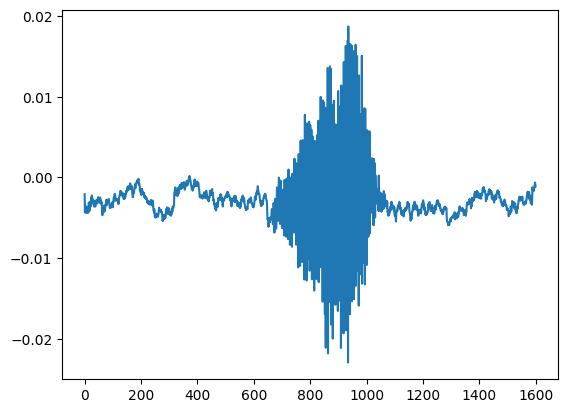

In [18]:
show_waveform(yes_waveform, yes_sample_rate, 'yes')

Waveform: tensor([[0.0072, 0.0061, 0.0055,  ..., 0.0098, 0.0085, 0.0092]])
Sample rate: 16000
Labels: no 

Shape of transformed waveform: torch.Size([1, 1600])
Sample rate: 1600.0


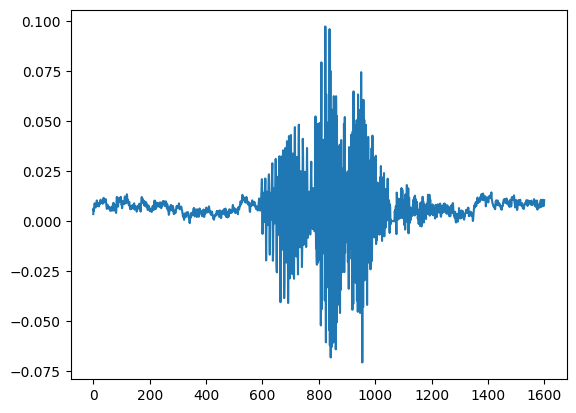

In [19]:
show_waveform(no_waveform, no_sample_rate, 'no')

## Spectrogram

So, what is a spectrogram? A spectrogram maps the frequency to time of an audio file, and it allows you to visualize audio data by frequency. It's in an image format. This image is what we'll use for our computer vision classification on the audio files. You can view the spectrogram image in grayscale, or in Red Green Blue (RGB) color format.

Every spectrogram image helps show the different features the sound signal produces in a color pattern. The convolutional neural network (CNN) treats the color patterns in the image as features for training the model to classify the audio.

Let's use the PyTorch `torchaudio.transforms` function to transform the waveform to a spectrogram image format.

In [20]:
def show_spectrogram(waveform_classA, waveform_classB):
    yes_spectrogram = torchaudio.transforms.Spectrogram()(waveform_classA)
    print("\nShape of yes spectrogram: {}".format(yes_spectrogram.size()))
    
    no_spectrogram = torchaudio.transforms.Spectrogram()(waveform_classB)
    print("Shape of no spectrogram: {}".format(no_spectrogram.size()))

    plt.figure()
    plt.subplot(1, 2, 1)
    plt.title("Features of {}".format('no'))
    plt.imshow(yes_spectrogram.log2()[0,:,:].numpy(), cmap='viridis')
    
    plt.subplot(1, 2, 2)
    plt.title("Features of {}".format('yes'))
    plt.imshow(no_spectrogram.log2()[0,:,:].numpy(), cmap='viridis') 

We'll use the waveform for the `yes` command to display the spectrogram images dimensions and color pattern in an RGB chart. We'll also compare the feature difference between the `yes` and `no` audio commands.

- The **y-axis** is the frequency of the audio.
- The **x-axis** is the time of the audio.
- The intensity of the image shows the amplitude of the audio. In the following spectrogram images, the high concentrate of the yellow color illustrates the amplitude of the audio.


Shape of yes spectrogram: torch.Size([1, 201, 81])
Shape of no spectrogram: torch.Size([1, 201, 81])


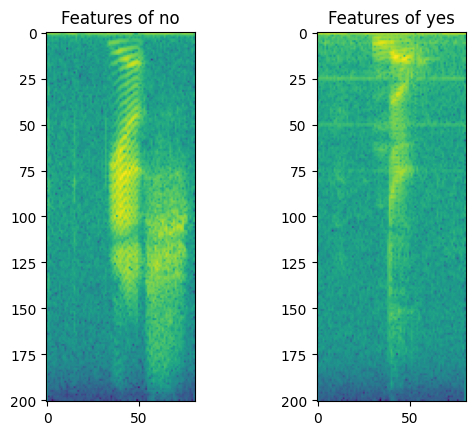

In [21]:
show_spectrogram(yes_waveform, no_waveform)

## Mel spectrogram

Mel spectrogram is also a frequency to time, but the frequency is converted to the Mel scale. The Mel scale takes the frequency and changes it, based on the perception of the sound of the scale or melody. This transforms the frequency within to the Mel scale, and then creates the spectrogram image.

In [22]:
def show_melspectrogram(waveform,sample_rate):
    mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate)(waveform)
    print("Shape of spectrogram: {}".format(mel_spectrogram.size()))

    plt.figure()
    plt.title("Features of {}".format('yes'))
    plt.imshow(mel_spectrogram.log2()[0,:,:].numpy(), cmap='viridis')

Shape of spectrogram: torch.Size([1, 128, 81])


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


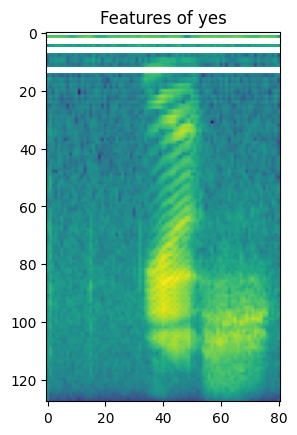

In [23]:
show_melspectrogram(yes_waveform, yes_sample_rate)

## Mel-frequency cepstral coefficients (MFCC)

A simplified explanation of what the MFCC does is that it takes our frequency, applies transforms, and the result is the amplitudes of the spectrum created from the frequency. Let's take a look at what this looks like.

In [24]:
def show_mfcc(waveform,sample_rate):
    mfcc_spectrogram = torchaudio.transforms.MFCC(sample_rate= sample_rate)(waveform)
    print("Shape of spectrogram: {}".format(mfcc_spectrogram.size()))

    plt.figure()
    fig1 = plt.gcf()
    plt.imshow(mfcc_spectrogram.log2()[0,:,:].numpy(), cmap='viridis')
    
    plt.figure()
    plt.plot(mfcc_spectrogram.log2()[0,:,:].numpy())
    plt.draw()

Shape of spectrogram: torch.Size([1, 40, 81])


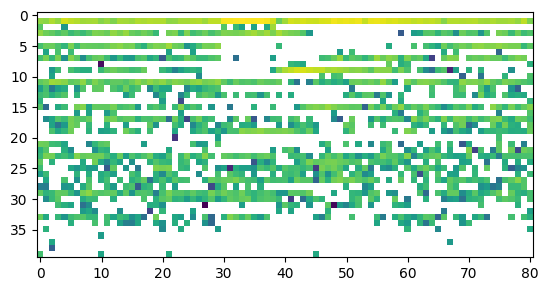

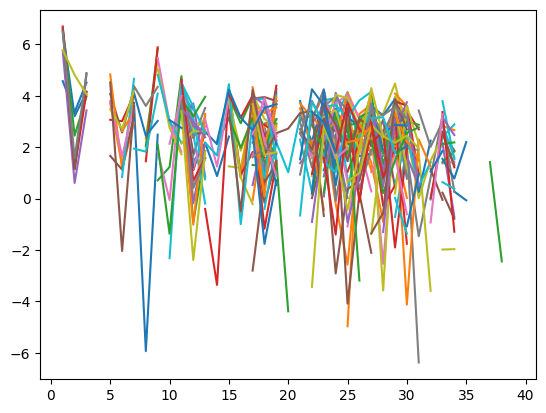

In [25]:
show_mfcc(no_waveform,  no_sample_rate)

## Image Generation from spectogram

The classification will be based on those images (spectogram images 


In [26]:
## spectogram image
def create_spectrogram_images(trainloader, label_dir):
    #make directory
    directory = f'./Data/spectrograms/{label_dir}/'
    if(os.path.isdir(directory)):
        print("Data exists for", label_dir)
    else:
        os.makedirs(directory, mode=0o777, exist_ok=True)
        
        for i, data in enumerate(trainloader):

            waveform = data[0]
            sample_rate = data[1][0]
            label = data[2]
            ID = data[3]

            # create transformed waveforms
            spectrogram_tensor = torchaudio.transforms.Spectrogram()(waveform)
            
            fig = plt.figure()
            plt.imsave(f'./Data/spectrograms/{label_dir}/spec_img{i}.png', spectrogram_tensor[0].log2()[0,:,:].numpy(), cmap='viridis')


In [27]:
### MFCC images
def create_mfcc_images(trainloader, label_dir):
    #make directory
    os.makedirs(f'./Data/mfcc_spectrograms/{label_dir}/', mode=0o777, exist_ok=True)
    
    for i, data in enumerate(trainloader):

        waveform = data[0]
        sample_rate = data[1][0]
        label = data[2]
        ID = data[3]
        
        mfcc_spectrogram = torchaudio.transforms.MFCC(sample_rate= sample_rate)(waveform)

        plt.figure()
        fig1 = plt.gcf()
        plt.imshow(mfcc_spectrogram[0].log2()[0,:,:].numpy(), cmap='viridis')
        plt.draw()
        fig1.savefig(f'./Data/mfcc_spectrograms/{label_dir}/spec_img{i}.png', dpi=100)
 
        #spectorgram_train.append([spectrogram_tensor, label, sample_rate, ID])

In [29]:
create_spectrogram_images(trainloader_yes, 'yes')
create_spectrogram_images(trainloader_no, 'no')

Data exists for yes
Data exists for no


# Building the speech model

## Spectogram images retrieval

As with the classic mnist classification problem, we load the images into a data loader which will allow us to easily handle the data.
`ImageFolder` is a helper class, which loads images into tensors.
The `Resize` operation allows us to normalize the images to the same size.

In [32]:
data_path = './Data/spectrograms' #looking in subfolder train

### ImageFolder creates the labels from the folder names and allows to create a complete dataset from multiple folders at the same time.
yes_no_dataset = datasets.ImageFolder( 
    root=data_path,
    transform=transforms.Compose([transforms.Resize((201,81)),
                                  transforms.ToTensor()
                                  ])
)

print(yes_no_dataset)

Dataset ImageFolder
    Number of datapoints: 7985
    Root location: ./Data/spectrograms
    StandardTransform
Transform: Compose(
               Resize(size=(201, 81), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )


In [33]:
class_map=yes_no_dataset.class_to_idx

print("\nClass category and index of the images: {}\n".format(class_map))


Class category and index of the images: {'no': 0, 'yes': 1}


## Building the training and the test sets

In [34]:
#split data to test and train
#use 80% to train
train_size = int(0.8 * len(yes_no_dataset))
test_size = len(yes_no_dataset) - train_size

### splits randomly the whole dataset with 80/20 ratio
yes_no_train_dataset, yes_no_test_dataset = torch.utils.data.random_split(yes_no_dataset, [train_size, test_size])

print("Training size:", len(yes_no_train_dataset))
print("Testing size:",len(yes_no_test_dataset))

Training size: 6388
Testing size: 1597


In [37]:
from collections import Counter

# labels in training set
train_classes = [label for _, label in yes_no_train_dataset]
Counter(train_classes)

Counter({1: 3270, 0: 3118})
3270


In [38]:
train_dataloader = torch.utils.data.DataLoader(
    yes_no_train_dataset,
    batch_size=15,
    num_workers=2,
    shuffle=True
)

test_dataloader = torch.utils.data.DataLoader(
    yes_no_test_dataset,
    batch_size=15,
    num_workers=2,
    shuffle=True
)

In [39]:
td = train_dataloader.dataset[0][0][0][0]
print(td)

tensor([0.1255, 0.1490, 0.1490, 0.1412, 0.2000, 0.1333, 0.2039, 0.1373, 0.1333,
        0.1373, 0.1725, 0.1412, 0.1412, 0.1176, 0.1294, 0.1176, 0.1373, 0.1294,
        0.2078, 0.1294, 0.2118, 0.1373, 0.1529, 0.1373, 0.1176, 0.1176, 0.1412,
        0.1451, 0.1294, 0.1608, 0.1176, 0.1412, 0.1176, 0.1333, 0.1373, 0.1255,
        0.1333, 0.1412, 0.1216, 0.1216, 0.1176, 0.1373, 0.1412, 0.2196, 0.1451,
        0.1255, 0.1294, 0.1216, 0.1373, 0.1529, 0.1647, 0.1569, 0.1569, 0.1608,
        0.1529, 0.1529, 0.2235, 0.1765, 0.1647, 0.2392, 0.1569, 0.1529, 0.2157,
        0.1529, 0.1804, 0.1647, 0.1686, 0.1412, 0.1647, 0.1882, 0.1804, 0.1412,
        0.1569, 0.2157, 0.1647, 0.2667, 0.2745, 0.1569, 0.1451, 0.1608, 0.1176])


In [42]:
print('Using {} device'.format(device))

Using mps device


## Create the convolutional neural network

[ ![Diagram showing a convolutional neural network.](./images/4-model-2.png) ](./images/4-model-2.png)

We'll define our layers and parameters:

- `conv2d`: Takes an input of 3 `channels`, which represents RGB colors because our input images are in color. The 32 represents the number of feature map images produced from the convolutional layer. The images are produced after you apply a filter on each image in a channel, with a 5 x 5 kernel size and a stride of 1. `Max pooling` is set with a 2 x 2 kernel size to reduce the dimensions of the filtered images. We apply the `ReLU` activation to replace the negative pixel values to 0.
- `conv2d`: Takes the 32 output images from the previous convolutional layer as input. Then, we increase the output number to 64 feature map images, after a filter is applied on the 32 input images, with a 5 x 5 kernel size and a stride of 1. `Max pooling` is set with a 2 x 2 kernel size to reduce the dimensions of the filtered images. We apply the `ReLU` activation to replace the negative pixel values to 0.
- `dropout`: Removes some of the features extracted from the `conv2d` layer with the ratio of 0.50, to prevent overfitting.
- `flatten`: Converts features from the `conv2d` output image into the linear input layer.
- `Linear`: Takes a number of 51136 features as input, and sets the number of outputs from the network to be 50 logits. The next layer will take the 50 inputs and produces 2 logits in the output layer. The `ReLU` activation function will be applied to the neurons across the linear network to replace the negative values to 0. The 2 output values will be used to predict the classification `yes` or `no`.  
- `log_Softmax`: An activation function applied to the 2 output values to predict the probability of the audio classification.

After defining the CNN, we'll set the device to run it.

In [47]:
class CNNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(51136, 50)
        self.fc2 = nn.Linear(50, 2)


    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        #x = x.view(x.size(0), -1)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        return F.log_softmax(x,dim=1)  

model = CNNet().to(device)
model

CNNet(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=51136, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=2, bias=True)
)

In [45]:
# cost function used to determine best parameters
cost = torch.nn.CrossEntropyLoss()

# used to create optimal parameters
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Create the training function

def train(dataloader, model, loss, optimizer):
    model.train()
    size = len(dataloader.dataset)
    for batch, (X, Y) in enumerate(dataloader):
        
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        pred = model(X)
        loss = cost(pred, Y)
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f'loss: {loss:>7f}  [{current:>5d}/{size:>5d}]')


# Create the validation/test function

def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad():
        for batch, (X, Y) in enumerate(dataloader):
            X, Y = X.to(device), Y.to(device)
            pred = model(X)

            test_loss += cost(pred, Y).item()
            correct += (pred.argmax(1)==Y).type(torch.float).sum().item()

    test_loss /= size
    correct /= size

    print(f'\nTest Error:\nacc: {(100*correct):>0.1f}%, avg loss: {test_loss:>8f}\n')

In [46]:
epochs = 15

for t in range(epochs):
    print(f'Epoch {t+1}\n-------------------------------')
    train(train_dataloader, model, cost, optimizer)
    test(test_dataloader, model)
print('Done!')

Epoch 1
-------------------------------
loss: 0.695189  [    0/ 6388]
loss: 0.660101  [ 1500/ 6388]
loss: 0.425006  [ 3000/ 6388]
loss: 0.449994  [ 4500/ 6388]
loss: 0.265772  [ 6000/ 6388]

Test Error:
acc: 91.9%, avg loss: 0.012365

Epoch 2
-------------------------------
loss: 0.187571  [    0/ 6388]
loss: 0.374738  [ 1500/ 6388]
loss: 0.091652  [ 3000/ 6388]
loss: 0.217516  [ 4500/ 6388]
loss: 0.185879  [ 6000/ 6388]

Test Error:
acc: 93.6%, avg loss: 0.009338

Epoch 3
-------------------------------
loss: 0.433215  [    0/ 6388]
loss: 0.265783  [ 1500/ 6388]
loss: 0.147407  [ 3000/ 6388]
loss: 0.213324  [ 4500/ 6388]
loss: 0.475370  [ 6000/ 6388]

Test Error:
acc: 93.7%, avg loss: 0.008612

Epoch 4
-------------------------------
loss: 0.050942  [    0/ 6388]
loss: 0.250009  [ 1500/ 6388]
loss: 0.075927  [ 3000/ 6388]
loss: 0.123793  [ 4500/ 6388]
loss: 0.323423  [ 6000/ 6388]

Test Error:
acc: 94.7%, avg loss: 0.008608

Epoch 5
-------------------------------
loss: 0.195840  [   

In [48]:
summary(model, input_size=(15, 3, 201, 81))

Layer (type:depth-idx)                   Output Shape              Param #
CNNet                                    [15, 2]                   --
├─Conv2d: 1-1                            [15, 32, 197, 77]         2,432
├─Conv2d: 1-2                            [15, 64, 94, 34]          51,264
├─Dropout2d: 1-3                         [15, 64, 94, 34]          --
├─Flatten: 1-4                           [15, 51136]               --
├─Linear: 1-5                            [15, 50]                  2,556,850
├─Linear: 1-6                            [15, 2]                   102
Total params: 2,610,648
Trainable params: 2,610,648
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 3.05
Input size (MB): 2.93
Forward/backward pass size (MB): 82.80
Params size (MB): 10.44
Estimated Total Size (MB): 96.17

In [50]:
model.eval()
test_loss, correct = 0, 0
class_map = ['no', 'yes']

with torch.no_grad():
    for batch, (X, Y) in enumerate(test_dataloader):
        X, Y = X, Y
        pred = model(X)
        print("Predicted:\nvalue={}, class_name= {}\n".format(pred[0].argmax(0),class_map[pred[0].argmax(0)]))
        print("Actual:\nvalue={}, class_name= {}\n".format(Y[0],class_map[Y[0]]))
        break

Predicted:
value=0, class_name= no

Actual:
value=0, class_name= no
